# 03 – Exploratory Data Analysis (EDA)

Purpose:
- Understand hourly/seasonal structure in pedestrian and cyclist counts
- Check how counts differ between daylight and darkness (raw)
- Produce plots that justify confounder controls (hour-of-day, seasonality) for later modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BIG_PATH = "../data/mdm2_data_files/big_table.csv"

big = pd.read_csv(BIG_PATH)
big["datetime"] = pd.to_datetime(big["datetime"], utc=True, errors="coerce")
big = big.dropna(subset=["datetime"])

big = big.sort_values(["sensor_id", "datetime"]).reset_index(drop=True)

print("Rows:", len(big))
print("Sensors:", big["sensor_id"].nunique())
big.head()


/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Rows: 509472
Sensors: 58


,ped,car,cyc,sensor_id,datetime,hour,date_only,dow,longitude,latitude
0,413,381,9,1,2024-01-01 00:00:00+00:00,0,2024-01-01,0,-2.591538,51.453815
1,402,489,10,1,2024-01-01 01:00:00+00:00,1,2024-01-01,0,-2.591538,51.453815
2,421,473,10,1,2024-01-01 02:00:00+00:00,2,2024-01-01,0,-2.591538,51.453815
3,370,419,4,1,2024-01-01 03:00:00+00:00,3,2024-01-01,0,-2.591538,51.453815
4,132,123,2,1,2024-01-01 04:00:00+00:00,4,2024-01-01,0,-2.591538,51.453815


In [2]:
def solar_altitude_deg(dt_utc, lat_deg, lon_deg):
    dts = pd.to_datetime(dt_utc, utc=True)
    n = dts.dt.dayofyear.to_numpy()
    hour = (dts.dt.hour + dts.dt.minute/60.0 + dts.dt.second/3600.0).to_numpy()
    lat = np.deg2rad(lat_deg)
    gamma = 2.0*np.pi/365.0 * (n - 1 + (hour - 12)/24.0)

    decl = (0.006918
            - 0.399912*np.cos(gamma) + 0.070257*np.sin(gamma)
            - 0.006758*np.cos(2*gamma) + 0.000907*np.sin(2*gamma)
            - 0.002697*np.cos(3*gamma) + 0.00148*np.sin(3*gamma))

    eqtime = 229.18*(0.000075
                     + 0.001868*np.cos(gamma) - 0.032077*np.sin(gamma)
                     - 0.014615*np.cos(2*gamma) - 0.040849*np.sin(2*gamma))

    tst = (hour*60.0 + eqtime + 4.0*lon_deg) % 1440.0
    ha = np.deg2rad((tst/4.0) - 180.0)

    cos_zen = np.sin(lat)*np.sin(decl) + np.cos(lat)*np.cos(decl)*np.cos(ha)
    cos_zen = np.clip(cos_zen, -1.0, 1.0)

    zen = np.arccos(cos_zen)
    alt = np.rad2deg(np.pi/2 - zen)
    return alt


In [3]:
big["solar_altitude_deg"] = np.nan

for sid, g in big.groupby("sensor_id", sort=False):
    lat = float(g["latitude"].iloc[0])
    lon = float(g["longitude"].iloc[0])
    big.loc[g.index, "solar_altitude_deg"] = solar_altitude_deg(g["datetime"], lat, lon)

alt = big["solar_altitude_deg"]
big["light_class"] = np.where(alt > 0, "daylight",
                       np.where(alt < -6, "darkness", "twilight"))

lit = big[big["light_class"] != "twilight"].copy()
lit["Dark"] = (lit["light_class"] == "darkness").astype(int)

lit["hour"] = lit["datetime"].dt.hour.astype(int)
lit["month"] = lit["datetime"].dt.month.astype(int)
lit["weekday"] = lit["datetime"].dt.dayofweek.astype(int)  # Mon=0,...Sun=6

print("Rows after dropping twilight:", len(lit))
lit.head()


Rows after dropping twilight: 478465


,ped,car,cyc,sensor_id,datetime,hour,date_only,dow,longitude,latitude,solar_altitude_deg,light_class,Dark,month,weekday
0,413,381,9,1,2024-01-01 00:00:00+00:00,0,2024-01-01,0,-2.591538,51.453815,-61.529806,darkness,1,1,0
1,402,489,10,1,2024-01-01 01:00:00+00:00,1,2024-01-01,0,-2.591538,51.453815,-60.225898,darkness,1,1,0
2,421,473,10,1,2024-01-01 02:00:00+00:00,2,2024-01-01,0,-2.591538,51.453815,-54.953852,darkness,1,1,0
3,370,419,4,1,2024-01-01 03:00:00+00:00,3,2024-01-01,0,-2.591538,51.453815,-47.266506,darkness,1,1,0
4,132,123,2,1,2024-01-01 04:00:00+00:00,4,2024-01-01,0,-2.591538,51.453815,-38.404055,darkness,1,1,0


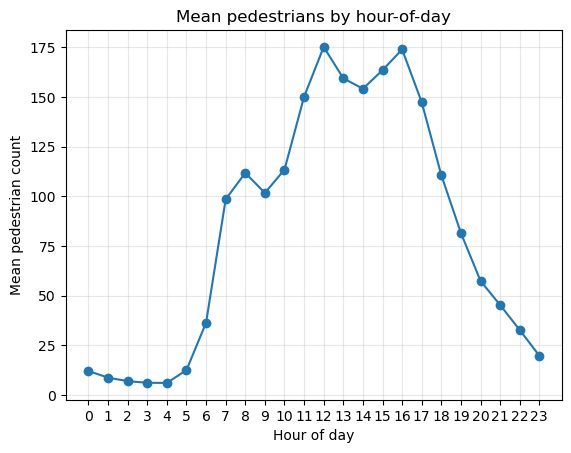

In [4]:
hour_means = lit.groupby("hour")[["ped","cyc"]].mean().sort_index()

plt.figure()
plt.plot(hour_means.index.to_numpy(), hour_means["ped"].to_numpy(), marker="o")
plt.xticks(range(0,24))
plt.xlabel("Hour of day")
plt.ylabel("Mean pedestrian count")
plt.title("Mean pedestrians by hour-of-day")
plt.grid(True, alpha=0.3)
plt.show()


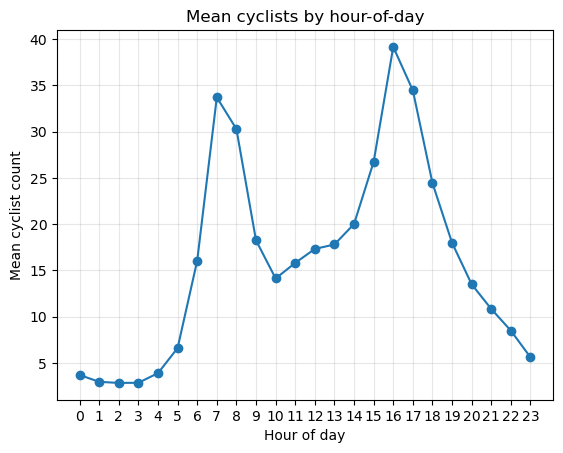

In [5]:
plt.figure()
plt.plot(hour_means.index.to_numpy(), hour_means["cyc"].to_numpy(), marker="o")
plt.xticks(range(0,24))
plt.xlabel("Hour of day")
plt.ylabel("Mean cyclist count")
plt.title("Mean cyclists by hour-of-day")
plt.grid(True, alpha=0.3)
plt.show()


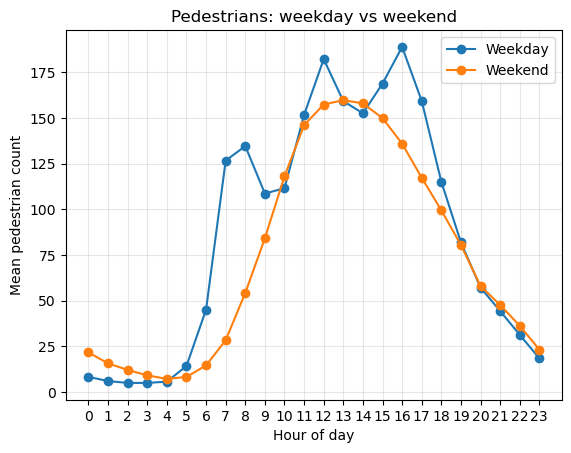

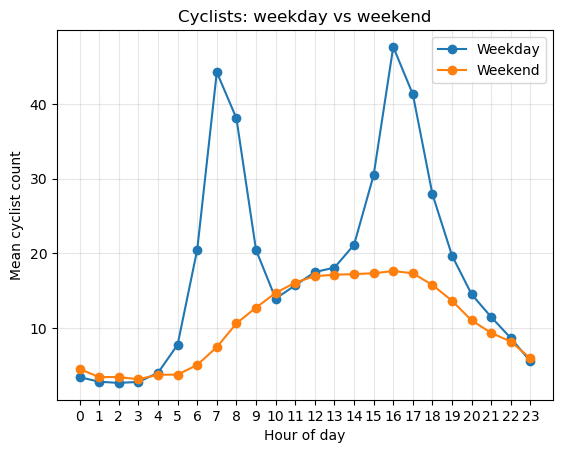

In [6]:
lit["is_weekend"] = (lit["weekday"] >= 5).astype(int)

wk = lit[lit["is_weekend"]==0].groupby("hour")[["ped","cyc"]].mean().sort_index()
we = lit[lit["is_weekend"]==1].groupby("hour")[["ped","cyc"]].mean().sort_index()

plt.figure()
plt.plot(wk.index.to_numpy(), wk["ped"].to_numpy(), marker="o", label="Weekday")
plt.plot(we.index.to_numpy(), we["ped"].to_numpy(), marker="o", label="Weekend")
plt.xticks(range(0,24))
plt.xlabel("Hour of day")
plt.ylabel("Mean pedestrian count")
plt.title("Pedestrians: weekday vs weekend")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure()
plt.plot(wk.index.to_numpy(), wk["cyc"].to_numpy(), marker="o", label="Weekday")
plt.plot(we.index.to_numpy(), we["cyc"].to_numpy(), marker="o", label="Weekend")
plt.xticks(range(0,24))
plt.xlabel("Hour of day")
plt.ylabel("Mean cyclist count")
plt.title("Cyclists: weekday vs weekend")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


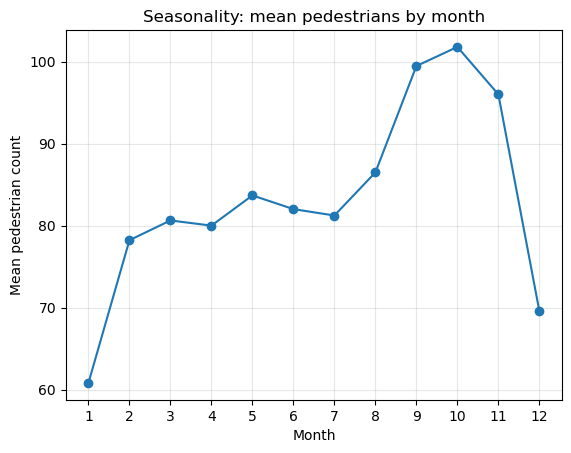

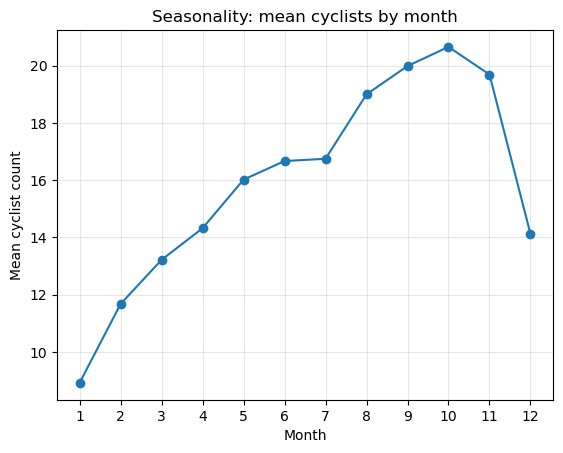

In [7]:
month_means = lit.groupby("month")[["ped","cyc"]].mean().sort_index()

plt.figure()
plt.plot(month_means.index.to_numpy(), month_means["ped"].to_numpy(), marker="o")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Mean pedestrian count")
plt.title("Seasonality: mean pedestrians by month")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(month_means.index.to_numpy(), month_means["cyc"].to_numpy(), marker="o")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Mean cyclist count")
plt.title("Seasonality: mean cyclists by month")
plt.grid(True, alpha=0.3)
plt.show()


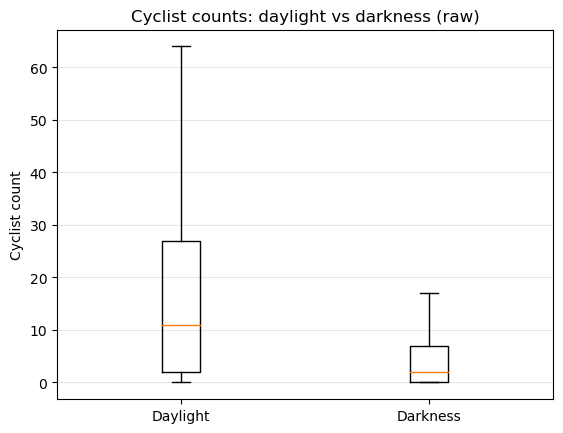

In [9]:
cyc_day = lit.loc[lit["Dark"]==0, "cyc"].dropna()
cyc_dark = lit.loc[lit["Dark"]==1, "cyc"].dropna()

plt.figure()
plt.boxplot([cyc_day.to_numpy(), cyc_dark.to_numpy()],
            labels=["Daylight", "Darkness"],
            showfliers=False)
plt.ylabel("Cyclist count")
plt.title("Cyclist counts: daylight vs darkness (raw)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

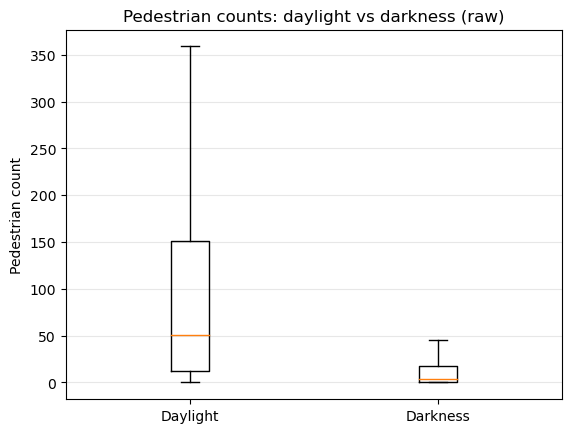

In [10]:
ped_day = lit.loc[lit["Dark"]==0, "ped"].dropna()
ped_dark = lit.loc[lit["Dark"]==1, "ped"].dropna()

plt.figure()
plt.boxplot([ped_day.to_numpy(), ped_dark.to_numpy()],
            labels=["Daylight", "Darkness"],
            showfliers=False)
plt.ylabel("Pedestrian count")
plt.title("Pedestrian counts: daylight vs darkness (raw)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


In [11]:
print("\n" + "="*90)
print("RESULTS: EXPLORATORY DATA ANALYSIS (EDA)".center(90))
print("="*90)
print("1) Strong hour-of-day structure is visible for both pedestrians and cyclists.")
print("   -> Later models must control for hour-of-day.")
print("2) Weekday and weekend profiles differ.")
print("   -> Later models must control for weekday/weekend.")
print("3) Monthly averages show seasonality.")
print("   -> Later models need a seasonal term (month or Fourier).")
print("4) Raw daylight vs darkness comparisons show differences in distribution.")
print("   -> Motivates formal case–control OR and time-series GLM estimation.")
print("="*90 + "\n")



                         RESULTS: EXPLORATORY DATA ANALYSIS (EDA)                         
1) Strong hour-of-day structure is visible for both pedestrians and cyclists.
   -> Later models must control for hour-of-day.
2) Weekday and weekend profiles differ.
   -> Later models must control for weekday/weekend.
3) Monthly averages show seasonality.
   -> Later models need a seasonal term (month or Fourier).
4) Raw daylight vs darkness comparisons show differences in distribution.
   -> Motivates formal case–control OR and time-series GLM estimation.

